## Práctica 3

In [3]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense, Dropout, InputLayer
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.layers import Dense, Dropout
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
import random
import shutil
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import EfficientNetB0

import matplotlib.pyplot as plt
import matplotlib as mpl


### Se definen funciones generales

In [5]:

def plot_samples_dataset(X, y):
    # Crear la grilla de 4x4
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    fig.suptitle('Grilla de imágenes del dataset Face Mask')

    # Iterar para mostrar 16 imágenes con sus etiquetas de forma aleatoria
    for i, ax in enumerate(axes.flat):
        idx = random.randint(0, len(X) - 1)
        img = X[idx].numpy().reshape(224, 224, 3)
        label = y[idx]
        #lleva a [0,1] si hace falta
        img_disp = img / 255.0 if img.max() > 1.0 else img
        ax.imshow(img_disp.astype("float32"))
        ax.set_title(f'{label}')
        ax.axis('off')
    plt.show()

def plot_loss_historia_keras(history):
    # Graficar el histórico de pérdida durante el entrenamiento
    plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida de Validación')
    plt.title('Pérdida durante el Entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.show()

def plot_acc_historia_keras(history):
    # Graficar la precisión durante el entrenamiento
    plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
    plt.title('Precisión durante el Entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Precisión')
    plt.legend()
    plt.show()


def plot_matriz_confusion(cm, tipo_modelo):
    # Visualizar la matriz de confusión usando Seaborn
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(3), yticklabels=range(3))
    plt.xlabel('Etiqueta predicha')
    plt.ylabel('Etiqueta real')
    plt.title(f'Matriz de Confusión para el {tipo_modelo} en el dataset de facemask')
    plt.show()


## Explicabilidad
def show_images(image_titles, images, cmap='viridis'):
    f, ax = plt.subplots(nrows=1, ncols=len(images), figsize=(4*len(images), 4))
    for i, title in enumerate(image_titles):
        ax[i].set_title(title, fontsize=12)
        ax[i].imshow(images[i], cmap=cmap)
        ax[i].axis('off')
    plt.tight_layout(); plt.show()

def show_images_with_heatmap(image_titles, images, cams, cmap='jet'):
    f, ax = plt.subplots(nrows=1, ncols=len(images), figsize=(4*len(images), 4))
    for i, title in enumerate(image_titles):
        heatmap = np.uint8(cm.get_cmap(cmap)(cam[i])[..., :3] * 255)
        ax[i].set_title(title, fontsize=12)
        ax[i].imshow(images[i].astype("uint8"))
        ax[i].imshow(heatmap, alpha=0.5)
        ax[i].axis('off')
    plt.tight_layout(); plt.show()


### Seteo de variables y limpieza de sesiones previas

In [7]:

# Limpiar la sesión de Keras
tf.keras.backend.clear_session()  # <- libera el grafo/sesión previa

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Fijar semillas para reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

base_dir = Path().resolve()
path_images = base_dir / "Dataset" / "images"
path_annotations = base_dir / "Dataset" / "annotations"
path_output = base_dir / "Dataset" / "images_processed"


#### Preprocesamiento de las imagenes

El procesamiento de las imagenes se mantiene igual que en la practica 2

In [9]:

shutil.rmtree(path_output, ignore_errors=True)
os.makedirs(path_output, exist_ok=True)

for xml_file in os.listdir(path_annotations):
    if not xml_file.endswith(".xml"):
        continue

    # Parsear el XML
    xml_path = os.path.join(path_annotations, xml_file)
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Cargar la imagen correspondiente
    nombre_imagen = xml_file.replace(".xml", ".png")
    img_path = os.path.join(path_images, nombre_imagen)
    img = Image.open(img_path)

    W, H = img.size

    # Recorrer cada objeto etiquetado
    for i, obj in enumerate(root.findall("object")):
        nombre_clase = obj.find("name").text

        # Coordenadas
        bbox = obj.find("bndbox")
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)

        pad = 0.20
        dx = int((xmax - xmin) * pad)
        dy = int((ymax - ymin) * pad)
        xmin = max(0, xmin - dx)
        ymin = max(0, ymin - dy)
        xmax = min(W, xmax + dx)
        ymax = min(H, ymax + dy)

        # Recortar
        recorte = img.crop((xmin, ymin, xmax, ymax))

        # Carpeta por clase
        carpeta_clase = os.path.join(path_output, nombre_clase)
        os.makedirs(carpeta_clase, exist_ok=True)

        # Guardar recorte
        recorte.save(os.path.join(carpeta_clase, f"{xml_file[:-4]}_{i}.png"))

#### 1- Preparación y limpieza de datos


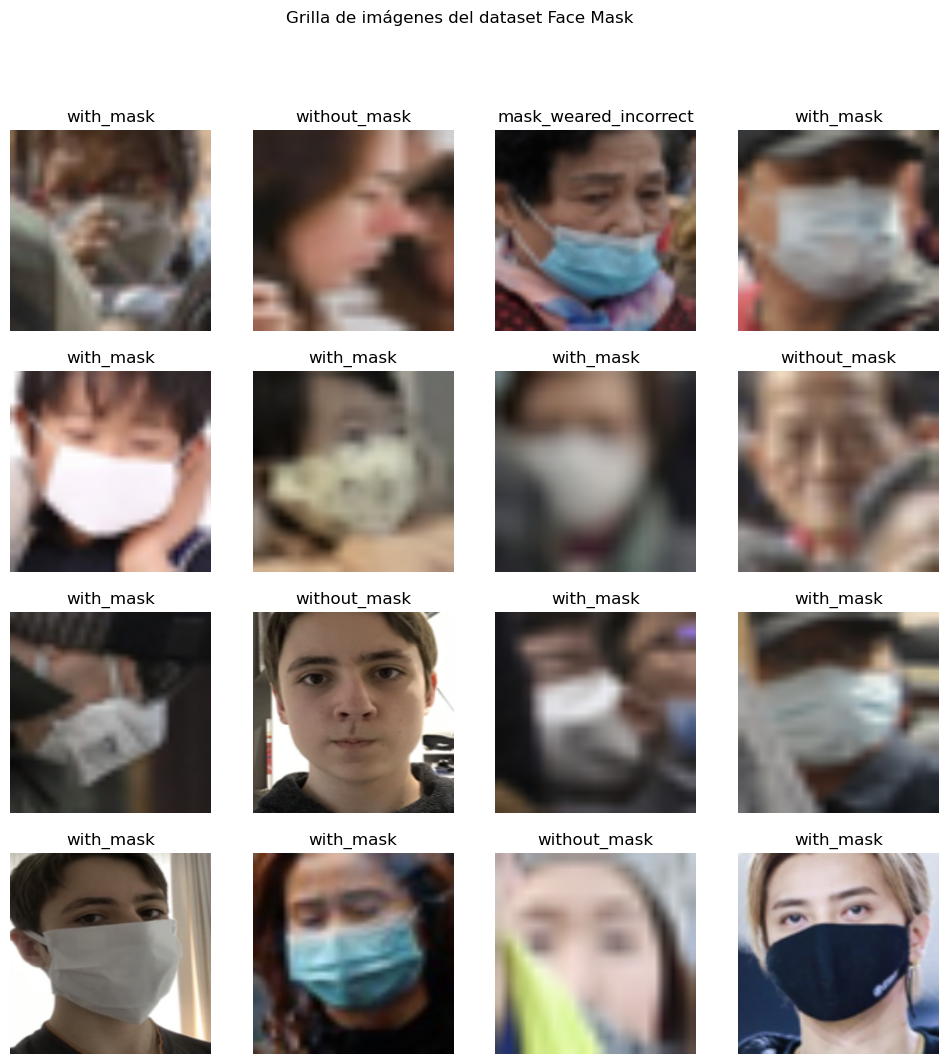

In [11]:

# Extraemos las imagenes y las aplanamos, verificamos despues que existan todas (4072)

# Función para cargar, redimensionar (sin importar si es más grande o más chica) y aplanar
def cargar_y_aplanar_imagenes(image_path, target_size=IMG_SIZE):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, target_size)  # redimensiona siempre a target_size
    return img

# Ruta base donde están las carpetas por categoría
ruta_base = base_dir / "Dataset" / "images_processed"

imagenes = []
etiquetas = []

# Recorremos cada carpeta (cada clase)
for clase in os.listdir(ruta_base):
    carpeta_clase = os.path.join(ruta_base, clase)
    if not os.path.isdir(carpeta_clase):
        continue

    # Recorremos cada imagen dentro de la carpeta
    for archivo in os.listdir(carpeta_clase):
        if archivo.lower().endswith('.png'):
            ruta_img = os.path.join(carpeta_clase, archivo)
            imagenes.append(cargar_y_aplanar_imagenes(ruta_img))
            etiquetas.append(clase)  # nombre de la carpeta como etiqueta

# Convertimos a tensores/arrays
imagenes = tf.stack(imagenes)  # (num_imagenes, 224*224*3)
etiquetas = np.array(etiquetas)

# Se visualiza ejemplo de imagenes
plot_samples_dataset(imagenes, etiquetas)


In [12]:

# Codificamos las etiquetas a números
le = LabelEncoder()
etiquetas_num = le.fit_transform(etiquetas)

#numero de clases
num_classes = len(le.classes_)
print(f"Número de clases: {num_classes}")

# Mostramos info de las clases
for i, clase in enumerate(le.classes_):
    print(f"{clase} : {i}")

# Conteo de elementos por clase
clases, conteos = np.unique(etiquetas_num, return_counts=True)
for clase, conteo in zip(clases, conteos):
    print(f"Clase {clase}: {conteo} elementos")

print(f"Total imágenes cargadas: {len(imagenes)}")

Número de clases: 3
mask_weared_incorrect : 0
with_mask : 1
without_mask : 2
Clase 0: 123 elementos
Clase 1: 3232 elementos
Clase 2: 717 elementos
Total imágenes cargadas: 4072


C:\Users\lenovo x250\AppData\Local\Temp\ipykernel_11536\759501302.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=etiquetas_num, palette='Set1')


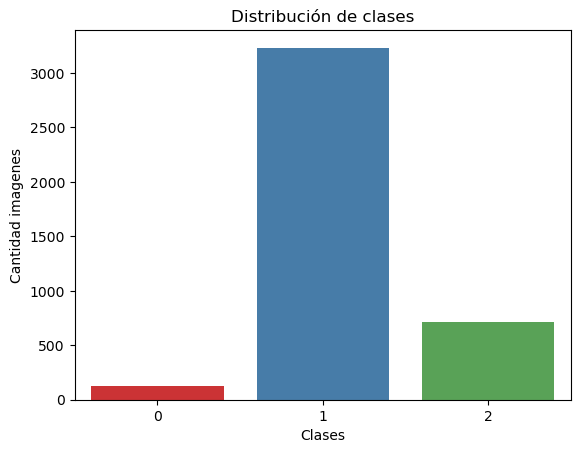

In [13]:

sns.countplot(x=etiquetas_num, palette='Set1')
plt.title('Distribución de clases')
plt.xlabel('Clases')
plt.ylabel('Cantidad imagenes')
plt.show()

#### 2- Creación del modelo

In [15]:

#Train / Test Split

imagenes_tensor = tf.convert_to_tensor(imagenes)

X_train, X_test, y_train, y_test = train_test_split(
    imagenes_tensor.numpy(), etiquetas_num, test_size=0.2, random_state=SEED, stratify=etiquetas_num)


n_muestras_test = X_test.shape[0]
dim_imagen = IMG_SIZE
n_canales = 3


In [16]:

# Train / Val Split
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2, random_state=SEED, stratify=y_train
)

n_muestras_train = X_tr.shape[0]
n_muestras_test = X_test.shape[0]
n_muestras_val = X_val.shape[0]

print(f"\nTamaño de datos de entrenamiento: {n_muestras_train}")
contador_train = Counter(y_tr)
for clase, cantidad in contador_train.items():
    print(f"Clase {clase}: {cantidad} imagenes")

print('Dimensión X_train: {}'.format(X_tr.shape))
print('Dimensión X_test: {}'.format(X_test.shape))
print('Dimensión X_val: {}'.format(X_val.shape))



Tamaño de datos de entrenamiento: 2605
Clase 1: 2068 imagenes
Clase 0: 78 imagenes
Clase 2: 459 imagenes
Dimensión X_train: (2605, 224, 224, 3)
Dimensión X_test: (815, 224, 224, 3)
Dimensión X_val: (652, 224, 224, 3)


Oversampling para mejorar el desbalanceo de clases

In [18]:
# Oversampling de clases minoritarias (se triplican)
# (Añadimos 2 copias extra de cada muestra de esas clases)

cont = Counter(y_tr)
max_count = max(cont.values())
minority_classes = [c for c, cnt in cont.items() if cnt < max_count]

if minority_classes:
    X_add_list = []
    y_add_list = []
    for c in minority_classes:
        idx = np.where(y_tr == c)[0]
        # se agregan 2 copias -> total por clase = 3x
        X_add_list.extend([X_tr[idx], X_tr[idx]])
        y_add_list.extend([y_tr[idx], y_tr[idx]])

    X_add = np.concatenate(X_add_list, axis=0) if X_add_list else np.empty((0,)+X_tr.shape[1:], dtype=X_tr.dtype)
    y_add = np.concatenate(y_add_list, axis=0) if y_add_list else np.empty((0,), dtype=y_tr.dtype)

    # Concatenamos y mezclamos para no introducir orden sesgado
    X_tr = np.concatenate([X_tr, X_add], axis=0)
    y_tr = np.concatenate([y_tr, y_add], axis=0)

    # Mezcla determinística
    rng = np.random.default_rng(SEED)
    perm = rng.permutation(len(y_tr))
    X_tr = X_tr[perm]
    y_tr = y_tr[perm]

    # Log de control
    print("\n[Oversampling] Clases minoritarias triplicadas:", minority_classes)
    nuevo_cont = Counter(y_tr)
    for clase, cantidad in sorted(nuevo_cont.items()):
        print(f"Clase {clase}: {cantidad} imágenes (post-oversampling)")
    print('Dimensión X_tr (post-oversampling):', X_tr.shape)
else:
    print("\n[Oversampling] No se detectaron clases minoritarias. No se aplicaron cambios.")

MemoryError: Unable to allocate 2.06 GiB for an array with shape (3679, 224, 224, 3) and data type float32

In [ ]:
#Codificación de categoricas y construcción de tf.data.Dataset

y_train_onehot = to_categorical(y_tr, num_classes=3)
y_val_onehot = to_categorical(y_val, num_classes=3)
y_test_onehot = to_categorical(y_test, num_classes=3)

train_dataset = tf.data.Dataset.from_tensor_slices((X_tr, y_train_onehot))
train_dataset = train_dataset.shuffle(buffer_size=len(X_tr)).batch(BATCH_SIZE, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val_onehot)).batch(BATCH_SIZE, drop_remainder=True)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test_onehot)).batch(BATCH_SIZE, drop_remainder=True)

train_dataset = train_dataset.cache().prefetch(AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(AUTOTUNE)

Transfer Learning con EfficientNetB0

In [ ]:
# Modelo TL (EfficientNetB0)
efn_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
efn_base.trainable = False  # Fase 1: solo cabeza

inputs = tf.keras.Input(shape=(224, 224, 3))
x = efn_base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Fase 1: entrenar solo la cabeza
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

earlystop_f1 = callbacks.EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)

history_f1 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[earlystop_f1]
)

In [ ]:
#  Fase 2: Fine-tuning de las capas superiores
# Descongelamos solo los últimos bloques de EfficientNetB0 (block6 y block7)

unfreeze_from_prefixes = ("block6", "block7")

for layer in efn_base.layers:
    # Congelar por defecto
    layer.trainable = False
    # Descongelar si pertenece a los últimos bloques y no es BatchNorm
    if any(layer.name.startswith(pfx) for pfx in unfreeze_from_prefixes):
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

# Re-compilar con LR bajo para FT (evita destruir el preentrenado)
fine_tune_lr = 1e-5
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tune_lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

earlystop_f2 = callbacks.EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)

# Class_weight para ponderar desbalance -> Mejora un poco recall a costa de precisión (poco efectivo)
#from sklearn.utils.class_weight import compute_class_weight
# import numpy as np
#cw = compute_class_weight(class_weight="balanced", classes=np.unique(y_tr), y=y_tr)
#class_weight = {i: w for i, w in enumerate(cw)}


history_f2 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,              # pocas épocas para evitar sobreajuste
    callbacks=[earlystop_f2]
#    ,class_weight=class_weight   # <- descomentar para usar class_weight
)

# Evaluación final después de Fase 2
test_loss, test_acc = model.evaluate(test_dataset)
print(f"[Fase 2] Accuracy en test: {test_acc:.4f}")

In [ ]:
plot_loss_historia_keras(history_f1)
plot_loss_historia_keras(history_f2)

In [ ]:
plot_acc_historia_keras(history_f1)
plot_acc_historia_keras(history_f2)

In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Convertir las predicciones en etiquetas (la clase con mayor probabilidad)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test_onehot.astype(int)  # Las etiquetas reales del conjunto de prueba

In [ ]:
# Generar el reporte de clasificación
print("Reporte de Clasificación para EfficientNetB0 con Transfer Learning de facemask:\n")
y_true_labels = np.argmax(y_true, axis=1)
print(classification_report(y_true_labels, y_pred_classes))

# Crear la matriz de confusión
cm = confusion_matrix(y_true_labels, y_pred_classes)

# Visualizar la matriz de confusión usando Seaborn
plot_matriz_confusion(cm, "EfficientNetB0")

In [ ]:
# Técnica de interpretación de modelos: Grad-CAM
# Visualización de mapas de activación por clase

class_names = le.classes_

# --- Submodelo: features pre-GAP + SALIDA SOFTMAX (K clases) ---
gap = next(l for l in model.layers if isinstance(l, tf.keras.layers.GlobalAveragePooling2D))
feat_t  = gap.input                 # (B,H,W,C)
probs_t = model.output              # (B,K)
feat_pred = tf.keras.Model(model.inputs, [feat_t, probs_t])

# --- Grad-CAM sobre un batch (explica la clase predicha por softmax) ---
def gradcam_batch(x, class_idx=None, out_size=(224,224)):
    x = tf.cast(x, tf.float32)
    with tf.GradientTape() as t:
        F, probs = feat_pred(x, training=False)              # (N,H,W,C),(N,K)
        if class_idx is None:
            class_idx = tf.argmax(probs, axis=1)
        class_idx = tf.cast(class_idx, tf.int32)
        idx = tf.stack([tf.range(tf.shape(probs)[0], dtype=tf.int32), class_idx], axis=1)
        score = tf.gather_nd(probs, idx)                     # (N,)
    g = t.gradient(score, F)
    w = tf.reduce_mean(g, axis=(1,2), keepdims=True)
    cam = tf.nn.relu(tf.reduce_sum(w * F, axis=-1))          # (N,H,W)
    cam = (cam - tf.reduce_min(cam, (1,2), True)) / (tf.reduce_max(cam, (1,2), True) + 1e-8)
    cam = tf.image.resize(cam[...,None], out_size)[...,0]
    return cam.numpy(), probs.numpy()

# --- 1 muestra por clase (orden 0..K-1) ---
def one_per_class(ds, k):
    got=[False]*k; imgs=[None]*k; y=[None]*k
    for x, yy in ds.unbatch():
        i=int(tf.argmax(yy));
        if not got[i]: imgs[i]=x.numpy(); y[i]=i; got[i]=True
        if all(got): break
    return np.stack(imgs), np.array(y, np.int32)

K = len(class_names)
imgs, y_true = one_per_class(test_dataset, K)
cams, probs  = gradcam_batch(imgs, out_size=(224,224))

# chequeo rápido
assert probs.shape[1] == K, f"Esperaba K={K} columnas en probs, obtuve {probs.shape[1]}"

pred_idx = np.argmax(probs, axis=1)
id2name = {i:n for i,n in enumerate(class_names)}
titles = [f"GT: {id2name.get(int(gt),'?')} | Pred: {id2name.get(int(p),'?')}"
          for gt,p in zip(y_true, pred_idx)]

# Visual
def show_triptych(imgs, cams, titles, cmap='jet', alpha=0.35):
    n=len(imgs); C=mpl.colormaps[cmap]
    plt.figure(figsize=(4*n,10))
    for i in range(n):
        img = imgs[i]

        # ---- preparar imagen para display ----
        if img.dtype != np.uint8:
            if np.max(img) > 1.5:
                img_disp = np.clip(img, 0, 255).astype('uint8')  # 0–255 -> uint8
            else:
                img_disp = np.clip(img, 0, 1)                    # ya está 0–1
        else:
            img_disp = img

        cam = np.clip(cams[i], 0, 1)
        heat = C(cam)[..., :3]

        ax = plt.subplot(3,n,i+1);     ax.set_title(titles[i], fontsize=11)
        ax.imshow(img_disp);           ax.axis('off')

        ax = plt.subplot(3,n,n+i+1);   ax.imshow(cam, cmap=cmap); ax.axis('off')

        ax = plt.subplot(3,n,2*n+i+1); ax.imshow(img_disp); ax.imshow(heat, alpha=alpha); ax.axis('off')
    plt.tight_layout(); plt.show()

show_triptych(imgs, cams, titles)